<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/Exponential%20Smoothing%20and%20Holt-Winters/Holt_Winters_AirMiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COURSE EXERCISE:

The Holt-Winters model is part of the Exponential
Smoothing family of models, and it is, as a result, also
called Triple Exponential Smoothing. Exponential
Smoothing is a process where the weight of the
information decays over time. Holt-Winters performs
exponential Smoothing on 3 levels: Level, Trend,
Seasonality.

Goals:
1. Data Frequency: You must specify the frequency of the
time series index. Please use "MS", for
Month Start, since the dates use the
first day of the month
2. Visualize the Data: Getting to know the Data is very
important, and visualization can
be very helpful for you to
understand better the trend,
cyclical patterns and even the
variability of the Time Series
3. Training and Test Set: Set the Test Set to be 12 months. The
easy way is to just set the last 12. The
goal of splitting between training and
test is to have an unbiased way of
assessing your model, since it only
knows the training data
4. Holt-Winters: Build the model with the time
series during the training period.
Please remember that Holt-Winters
does not allow external regressors
5. Forecasting: Ready, set, go. Forecast 12 months using
the model. You are also encouraged to
visualize the results.
6. Accuracy Assessment: Please assess the accuracy of the
model using the MAE.

### SET-UP

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/CAPSTONE PROJECT - Airmiles

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/CAPSTONE PROJECT - Airmiles


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [12]:
# Load Dataset
df = pd.read_csv("airmiles.csv", index_col="Date", parse_dates=True, dayfirst=True)
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 1996-01-01 to 2005-05-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   airmiles  113 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


In [14]:
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq=None)

In [15]:
# Rename target to y
df = df.rename(columns= {'airmiles':'y'})

# Change frequency to monthly
df = df.asfreq("MS")

df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq='MS')

### EDA

#### Trends & Seasonality

/tmp/ipython-input-1659169807.py:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df['y'].resample('Q').mean(), ylabel='Airmiles', ax=ax3)


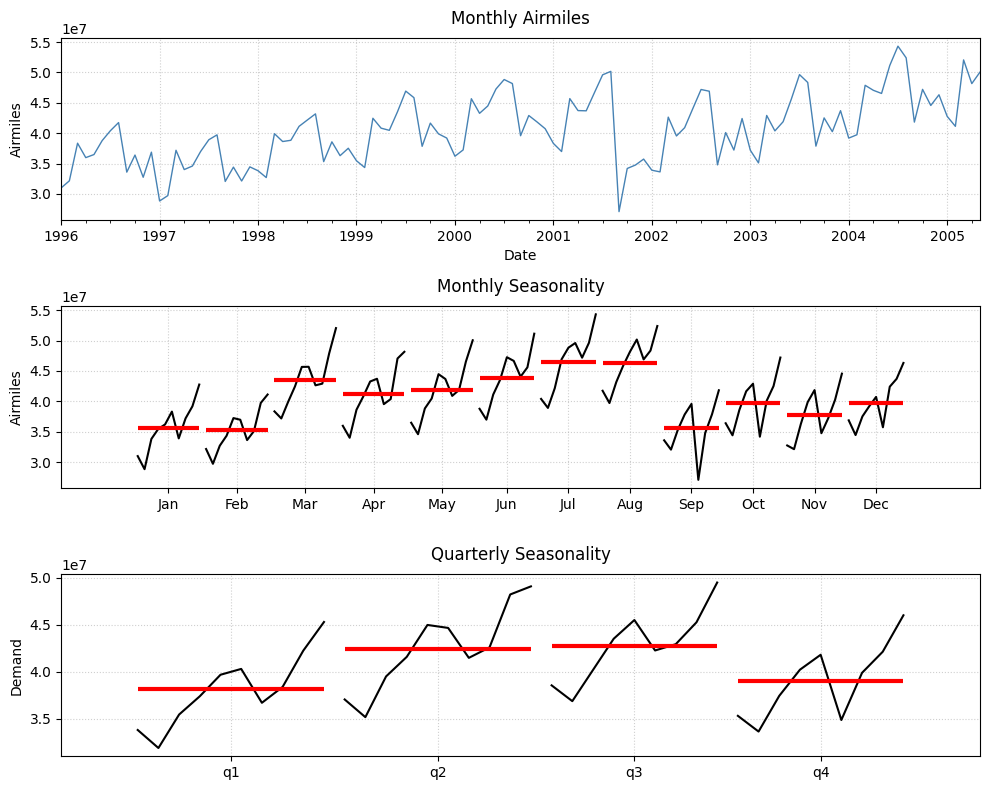

In [18]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

# Monthly Plot (instead of daily)
df['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Monthly Airmiles', fontsize=12, pad=10)
ax1.set_ylabel('Airmiles', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df['y'], ylabel='Airmiles', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Airmiles', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df['y'].resample('Q').mean(), ylabel='Airmiles', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Demand', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


#### Decomposition Plot

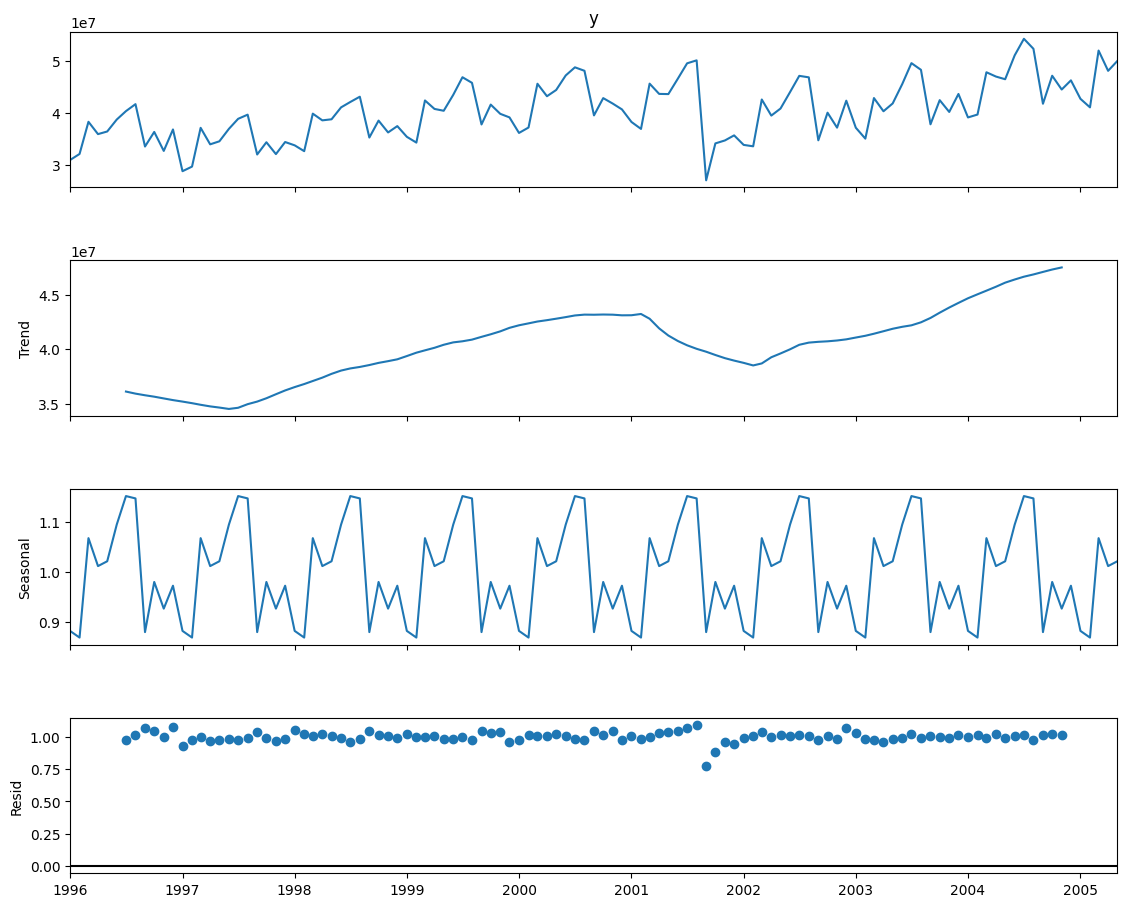

In [19]:
# Decomposition Plot
decomposition = seasonal_decompose(df['y'],
                                   model='multiplicative',
                                   period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

#### ACF and PACF

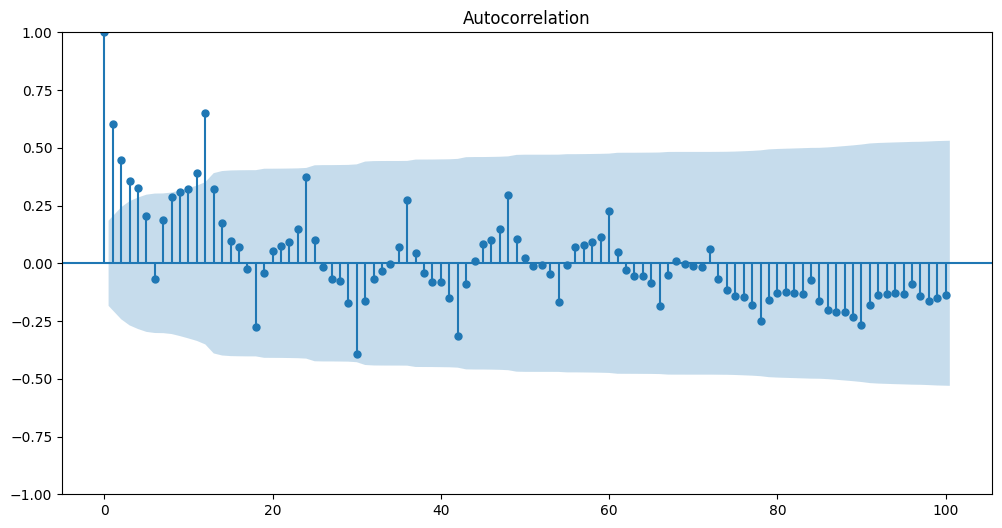

In [20]:
# ACF plot to see correlation of the series with lagged values
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['y'], lags=100, ax=ax)
plt.show()

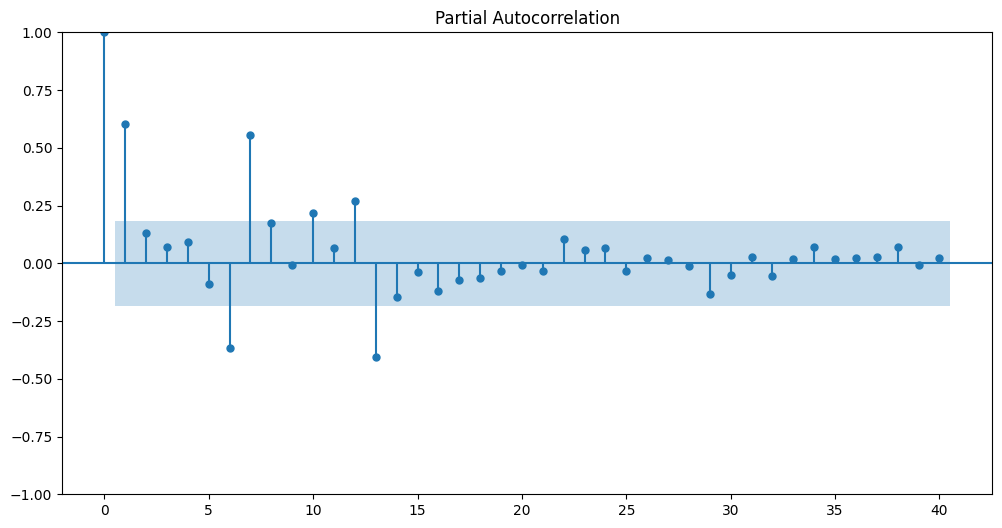

In [22]:
# PACF plot to see partial correlation (effect after removing intermediate lags)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df['y'], lags=40, ax=ax)
plt.show()

### Holt Winters

#### Train and Test Split

In [25]:
# Test Split is the last 12 months
train = df.iloc[:-12]
test = df.iloc[-12:]

period = 12

#### Model Fitting

In [26]:
# Build the Holt-Winters model with both trend and seasonality
# Using seasonal_periods=12 for monthly data, with a multiplicative season
model_holt = ExponentialSmoothing(
    endog=train,
    trend="mul",
    seasonal="mul",
    seasonal_periods=12
).fit()
print(model_holt.summary())

                        ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                   101
Model:             ExponentialSmoothing   SSE                 254388494544808.312
Optimized:                         True   AIC                            2916.031
Trend:                   Multiplicative   BIC                            2957.873
Seasonal:                Multiplicative   AICC                           2924.373
Seasonal Periods:                    12   Date:                  Fri, 26 Sep 2025
Box-Cox:                          False   Time:                          07:36:02
Box-Cox Coeff.:                    None                                          
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5337529                alpha                 True
smoothing_trend 

In [28]:
# Forecast the next 12 months
holt_pred = model_holt.forecast(period)
holt_pred[:5]

,0
2004-06-01,5.008194e+07
2004-07-01,5.296881e+07
2004-08-01,5.297759e+07
2004-09-01,4.026247e+07
2004-10-01,4.514114e+07


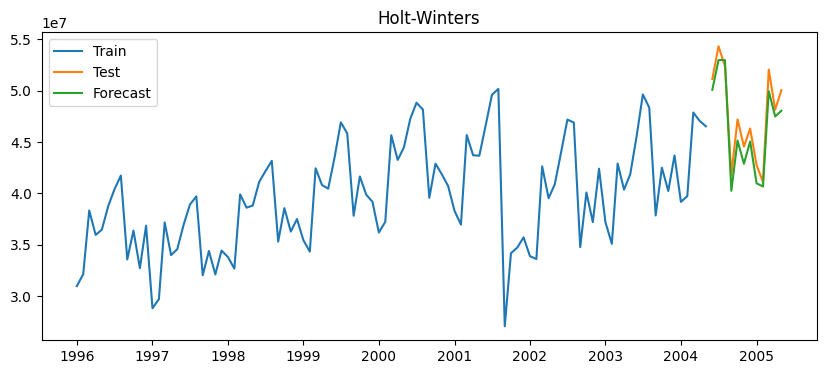

RMSE: 1485760
MAE: 1375680
MAPE: 2.9 %


In [31]:
# Function that assesses the model and visualizes the train, test and forecast
def model_assessment(train, test, predictions, chart_title = None):
  """
  Visualize and evaluate forecasts using RMSE, MAE, MAPE metrics.
  """

  # Set the chart size
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast
  plt.plot(train, label = "Train")
  plt.plot(test, label = "Test")
  plt.plot(predictions, label = "Forecast")
  plt.title(chart_title)
  plt.legend()
  plt.show()

  # Calculate and print the RMSE, MAE, and MAPE
  rmse = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)
  print(f"RMSE: {rmse:.0f}")
  print(f"MAE: {mae:.0f}")
  print(f"MAPE: {100 * mape:.1f} %")

model_assessment(train, test, holt_pred, "Holt-Winters")

#### Forecast the future

In [32]:
# Build a Holt-Winters model using the complete dataset
model_holt_complete = ExponentialSmoothing(
    endog=df.y,
    trend="mul",
    seasonal="mul",
    seasonal_periods=12
).fit()

In [33]:
# Forecast the next 12 months beyond the existing data
forecast = model_holt_complete.forecast(period)
forecast[:5]

,0
2005-06-01,5.333951e+07
2005-07-01,5.645173e+07
2005-08-01,5.616240e+07
2005-09-01,4.298747e+07
2005-10-01,4.825186e+07


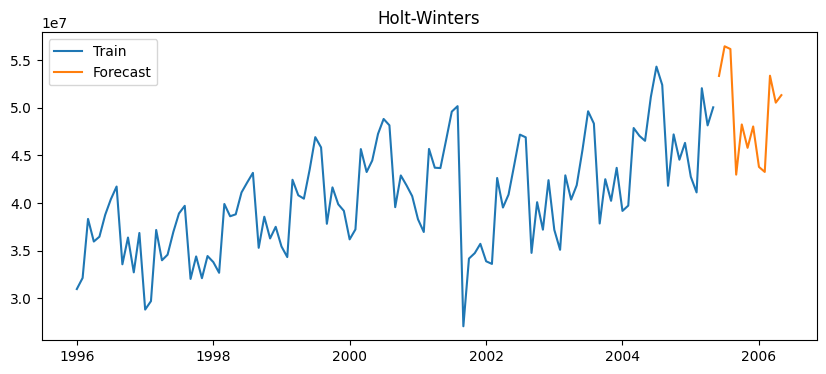

In [34]:
def plot_future(y, forecast, chart_title = None):
  """
  Plots the historical data and future forecasts on the same axis.
  """

  # Plot the training data and forecast
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast
  plt.plot(y, label = "Train")
  plt.plot(forecast, label = "Forecast")

  # Add a title and legend to the plot
  plt.title(chart_title)
  plt.legend()
  plt.show()

# Apply the function
plot_future(df.y, forecast, "Holt-Winters")